In [1]:
import csv, os, glob, torch, time
from tqdm import tqdm
from utils.module import write_to_csv
from utils.autoencoder import VAE, vae_loss
from dataloader.dataset import UnlabeledDataset2, UnlabeledTransform2
import torch.utils.data as data
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
!nvidia-smi

Tue Nov  7 05:39:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla M60                      On  | 00000000:00:1B.0 Off |                    0 |
| N/A   26C    P8              15W / 150W |      0MiB /  7680MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import cv2, random
import numpy as np

cfd_files = sorted(glob.glob('data/Train/images/CFD*'))
random.shuffle(cfd_files)
crack500_files = sorted(glob.glob('data/Train/images/CRACK500*'))
random.shuffle(crack500_files)
cracktree200_files = sorted(glob.glob('data/Train/images/cracktree200*'))
random.shuffle(cracktree200_files)
deepcrack_files = sorted(glob.glob('data/Train/images/DeepCrack*'))
random.shuffle(deepcrack_files)
# eugenmuller_files = sorted(glob.glob('data/Train/images/Eugen_Muller*'))
# random.shuffle(eugenmuller_files)
gaps384_files = sorted(glob.glob('data/Train/images/GAPS384*'))
random.shuffle(gaps384_files)
noncrack_files = sorted(glob.glob('data/Train/images/noncrack*'))
random.shuffle(noncrack_files)
rissbilder_files = sorted(glob.glob('data/Train/images/Rissbilder*'))
random.shuffle(rissbilder_files)
volker_files = sorted(glob.glob('data/Train/images/Volker*'))
random.shuffle(volker_files)
chun_files = sorted(glob.glob('data/original_split_resized/*'))
random.shuffle(chun_files)

img_file_path = cfd_files[:100]+crack500_files[:100]+cracktree200_files[:100]+deepcrack_files[:100]+gaps384_files[:100]+noncrack_files[:100]+rissbilder_files[:100]+volker_files[:100]+chun_files[:100]

tsne = TSNE(n_jobs=2, perplexity=20) 
imgs = np.concatenate([cv2.resize(cv2.imread(p),(256,256)).flatten().reshape(1,-1) for p in img_file_path], axis=0)
imgs_reduced = tsne.fit_transform(imgs)

print(imgs_reduced.shape)

(900, 2)


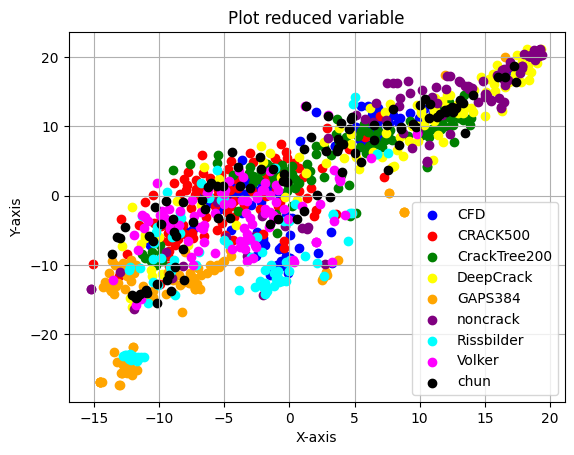

In [10]:
parts = [imgs_reduced[i * 100: (i + 1) * 100] for i in range(9)]

# プロットのループ
plt.scatter(parts[0][:, 0], parts[0][:, 1], label='CFD', c='blue', marker='o')
plt.scatter(parts[1][:, 0], parts[1][:, 1], label='CRACK500', c='red', marker='o')
plt.scatter(parts[2][:, 0], parts[2][:, 1], label='CrackTree200', c='green', marker='o')
plt.scatter(parts[3][:, 0], parts[3][:, 1], label='DeepCrack', c='yellow', marker='o')
plt.scatter(parts[4][:, 0], parts[4][:, 1], label='GAPS384', c='orange', marker='o')
plt.scatter(parts[5][:, 0], parts[5][:, 1], label='noncrack', c='purple', marker='o')
plt.scatter(parts[6][:, 0], parts[6][:, 1], label='Rissbilder', c='cyan', marker='o')
plt.scatter(parts[7][:, 0], parts[7][:, 1], label='Volker', c='magenta', marker='o')
plt.scatter(parts[8][:, 0], parts[8][:, 1], label='chun', c='black', marker='o')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot reduced variable')
plt.grid(True)
plt.show()

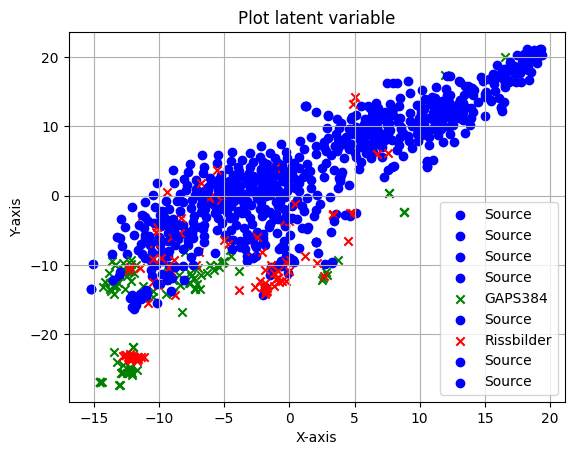

In [11]:
parts = [imgs_reduced[i * 100: (i + 1) * 100] for i in range(9)]

# プロットのループ
plt.scatter(parts[0][:, 0], parts[0][:, 1], label='Source', c='blue', marker='o')
plt.scatter(parts[1][:, 0], parts[1][:, 1], label='Source', c='blue', marker='o')
plt.scatter(parts[2][:, 0], parts[2][:, 1], label='Source', c='blue', marker='o')
plt.scatter(parts[3][:, 0], parts[3][:, 1], label='Source', c='blue', marker='o')
plt.scatter(parts[4][:, 0], parts[4][:, 1], label='GAPS384', c='green', marker='x')
plt.scatter(parts[5][:, 0], parts[5][:, 1], label='Source', c='blue', marker='o')
plt.scatter(parts[6][:, 0], parts[6][:, 1], label='Rissbilder', c='red', marker='x')
plt.scatter(parts[7][:, 0], parts[7][:, 1], label='Source', c='blue', marker='o')
plt.scatter(parts[8][:, 0], parts[8][:, 1], label='Source', c='blue', marker='o')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot latent variable')
plt.grid(True)
plt.show()

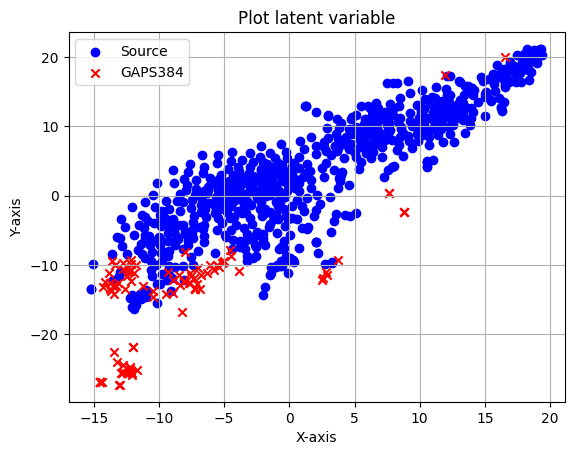

In [13]:
imgs_reduced_part1 = np.concatenate([imgs_reduced[:400],imgs_reduced[500:600],imgs_reduced[700:]])
imgs_reduced_part2 = imgs_reduced[400:500]

plt.scatter(imgs_reduced_part1[:,0], imgs_reduced_part1[:,1], label='Source', c='blue', marker='o')
plt.scatter(imgs_reduced_part2[:,0], imgs_reduced_part2[:,1], label='GAPS384', c='red', marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot latent variable')
plt.grid(True)
plt.show()

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import cv2, random
import numpy as np

img_file_path1 = sorted(glob.glob('data/Train/images/*'))
random.shuffle(img_file_path1)
img_file_path2 = sorted(glob.glob('data/original_split_resized/*'))
random.shuffle(img_file_path2)

img_file_path = img_file_path1[:500]+img_file_path2[:500]

tsne = TSNE(n_jobs=2, perplexity=20) 
imgs = np.concatenate([cv2.resize(cv2.imread(p),(256,256)).flatten().reshape(1,-1) for p in img_file_path], axis=0)
imgs_reduced = tsne.fit_transform(imgs)

print(imgs_reduced.shape)


In [ ]:
imgs_reduced_part1 = imgs_reduced[:500]
imgs_reduced_part2 = imgs_reduced[500:]

plt.scatter(imgs_reduced_part1[:,0], imgs_reduced_part1[:,1], label='Source', c='blue', marker='o')
plt.scatter(imgs_reduced_part2[:,0], imgs_reduced_part2[:,1], label='Target', c='red', marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot latent variable')
plt.grid(True)
plt.show()

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im_list = [OffsetImage(plt.imread(str(p)), zoom=zoom) for p in image_list]
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, im_list):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# perplexity: 20
fig, ax = plt.subplots(figsize=(30,30))
imscatter(imgs_reduced[:,0], imgs_reduced[:,1], img_file_path, ax=ax, zoom=0.2)

plt.show()

In [ ]:
class CenterCropTransform():
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, image):
        image = transforms.CenterCrop((self.crop_size, self.crop_size))(image)

        # テンソルに変換
        image = transforms.ToTensor()(image)

        return image

In [ ]:
img_file_path = sorted(glob.glob('data/Train/images/*'))
img_file_path2 = sorted(glob.glob('data/original_split_resized/*'))
img_list = img_file_path + img_file_path2

train_dataset = UnlabeledDataset2(
    img_list, transform=CenterCropTransform(crop_size=32))
train_dataloader = data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

In [ ]:
# train_dataloaderから次のバッチを取得
data_iterator = iter(train_dataloader)
imgs = next(data_iterator)

# バッチ内の最初の画像を取得
single_image = imgs[0]

# 画像をNumPy配列に変換
single_image = single_image.numpy()

# 画像をMatplotlibで表示
plt.imshow(single_image.transpose(1, 2, 0))  # チャンネルの次元を最後に移動
plt.show()


In [ ]:
# VAEモデルのインスタンス化
model = VAE(latent_dim=50)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# オプティマイザを定義
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Epochs
num_epochs = 1000

In [ ]:
project = 'vae50'
earlystopping = EarlyStopping(patience=50)
os.makedirs('weights/'+ project, exist_ok=True)
# model.load_state_dict(torch.load('weights/vae2/best.pth'))
model = model.to(device)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # モデルをトレーニングモードに設定
    running_loss = 0.0

    for inputs in tqdm(train_dataloader):
        inputs = inputs.to(device)
        optimizer.zero_grad()  # 勾配をゼロに初期化
        outputs, mu, logvar, z = model(inputs)  # フォワードパス
        loss = vae_loss(outputs, inputs, mu, logvar)  # 損失を計算
        loss.backward()  # 逆伝播
        optimizer.step()  # パラメータを更新
        running_loss += loss.item()
    
    epoch_train_loss = running_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")

    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    with torch.no_grad():
        # Early Stopping
        earlystopping(epoch_train_loss)

        if earlystopping.early_stop:
            print("Early stopping")
            break
        if earlystopping.counter == 0:
            # download to CPU
            torch.save(model.to('cpu').state_dict(), 'weights/'+ project + '/best.pth')
            # upload to GPU
            model = model.to(device)

        print(f'Early Stopping Counter = {earlystopping.counter}')

torch.save(model.to('cpu').state_dict(), 'weights/'+ project + '/last.pth')

In [ ]:
def encode(img_path, model):
    image = Image.open(img_path)

    # 画像を指定された形状にリサイズ
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()  # Tensorに変換
    ])
    image = transform(image)

    # バッチ次元を追加
    image = image.unsqueeze(0)
    
    output, _, _, z = model(image)
    
    return image, output, z

In [ ]:
model = VAE(latent_dim=50)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('weights/vae50/best.pth'))
model = model.to(device)

img_path = "data/Train/images/Volker_DSC01611_102_962_1355_1128.jpg"
image, output, z = encode(img_path, model)
output = output.cpu().detach()
print(z.cpu().detach())

# 1行2列のサブプロットを作成
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# imageを表示
image = image.squeeze(0).numpy().transpose(1, 2, 0)  # バッチ次元を削除し、チャンネルの次元を最後に移動
axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis('off')

# outputを表示
output = output.squeeze(0).numpy().transpose(1, 2, 0)  # バッチ次元を削除し、チャンネルの次元を最後に移動
axes[1].imshow(output)
axes[1].set_title("Output")
axes[1].axis('off')

plt.show()

In [ ]:
# SourceとTargetから500サンプルずつ潜在変数に変換してプロット
import random
source_file_path = sorted(glob.glob('data/Train/images/*'))
random.shuffle(source_file_path)
target_file_path = sorted(glob.glob('data/original_split_resized/*'))
random.shuffle(target_file_path)

source_z_list = []
target_z_list = []

model = VAE(latent_dim=2)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('weights/vae2/best.pth'))
model = model.to(device)

for i in range(500):
    _, _, z = encode(source_file_path[i], model)
    z = z.cpu().detach().squeeze(0).numpy()
    source_z_list.append(z)
    
for i in range(500):
    _, _, z = encode(target_file_path[i], model)
    z = z.cpu().detach().squeeze(0).numpy()
    target_z_list.append(z)    

# listには500個の2次元numpy配列が格納されている
# sourceとtargetの座標をプロット
plt.scatter(*zip(*source_z_list), label='Source', c='blue', marker='o')
plt.scatter(*zip(*target_z_list), label='Target', c='red', marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot latent variable')
plt.grid(True)
plt.show()